<a href="https://colab.research.google.com/github/kei-mo/bayesian-ml/blob/main/chapter4_3_5_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 混合ポアソンモデルにおけるベイズ推論

書籍：ベイズ推論による機械学習入門 4.3.5項の内容  


In [2]:
import numpy as np
from scipy.stats import poisson, gamma, dirichlet,nbinom
from scipy.special import psi # ディガンマ関数
from matplotlib import pyplot as plt
import dataclasses
import time

In [3]:
import plotly
import plotly.graph_objs as go
import plotly.io as pio
from plotly.subplots import make_subplots

list_color = plotly.colors.qualitative.D3 
pio.renderers.default = "colab"
plotly.__version__

'4.4.1'

## 混合ガウス分布のベイズ推定　解説

### やりたいこと
観測データが得られたときに、混合ポアソン分布の各パラメータの分布を推定（=ベイズ推論）する。  
ベイズ推論をすると観測データに対する予測モデルをつくることができる。   
今回は予め観測データが一定数得られていたときに、そのデータをまとめて推論に用いる

### 方法









### ELBO




* パラメータの収束の判定
* モデル選択
等に使うことができる。


$$
\begin{aligned}
\ln p(\bf{X}) &= ln \int p(\mathbf{X},\mathbf{Z})d\mathbf{Z} \\
              &= ln  \int q(\mathbf{Z}) \frac{p(\mathbf{X},\mathbf{Z})}{q(\mathbf{Z})}d\mathbf{Z} \\
              & \geq \int  q(\mathbf{Z}) ln \frac{p(\mathbf{X},\mathbf{Z})}{q(\mathbf{Z})}d\mathbf{Z}  \text{・・・(イェンセンの不等式)} \\
              &= \mathcal{L}[q(\mathbf{Z})]
\end{aligned} 
$$


$$
\begin{aligned}
\mathcal{L}[q(\mathbf{Z})] &= \int  q(\mathbf{Z}) ln \frac{p(\mathbf{X},\mathbf{Z})}{q(\mathbf{Z})}d\mathbf{Z}  \\
&= E[ ln \frac{p(X,Z)}{q(Z)}] \\
&= E[lnp(X,Z)] - E[lnq(Z)] \\
\end{aligned} 
$$

各項について計算

$$
\begin{aligned}
E[lnp(X,Z)] &= E[lnp(X|S,\lambda)+E[lnp(S|\pi)]+E[lnp(\pi)] +E[lnp(\lambda)] \\
 E[lnq(Z)] &= E[lnq(S)] + E[lnq(\pi)] + E[lnq(\lambda)] 
\end{aligned} 
$$

$$
\begin{aligned}
\mathcal{L}[q(\mathbf{Z})] &= E[lnp(X,Z)] - E[lnq(Z)] \\
              &= E[lnp(X|S,\lambda)+E[lnp(S|\pi)] 
                   - E[lnq(S)] +E[lnp(\pi)]- E[lnq(\pi)] +E[lnp(\lambda)] - E[lnq(\lambda)] 
\end{aligned} 
$$


$$
\begin{aligned}
\mathcal{L}[q] 
&= \sum^{N}_{n=1}\langle lnp(x_n|\mathbf{s}_n,\mathbf{\lambda})\rangle_{q(\mathbf{s}_n),q(\mathbf{\lambda})} 
  +\sum^{N}_{n=1}\langle lnp(\mathbf{s}_n|\mathbf{\pi}) \rangle_{q(\mathbf{s}_n),q(\mathbf{\pi})} 
  -\sum^{N}_{n=1}\langle ln q(\mathbf{s}_n) \rangle_{q(\mathbf{s}_n)} 
  -KL[q(\mathbf{\lambda})||p(\mathbf{\lambda})]
  -KL[q(\mathbf{\pi})||p(\mathbf{\pi})]
\end{aligned} 
$$

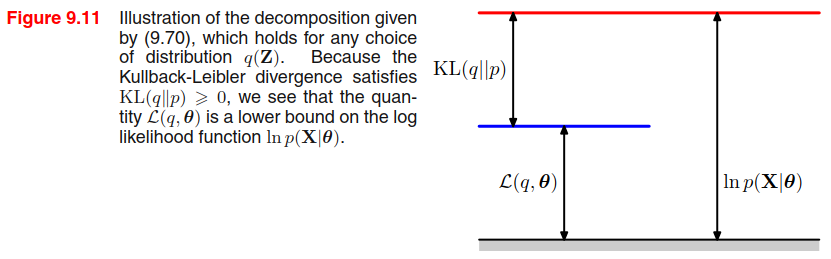

#### 事前分布の設定
* ポアソン分布$Poi(\mathbf{X}|\mathbf{\lambda})$の事前分布としてガンマ分布$Gam(\lambda|a,b)$を設定する  
* カテゴリカル分布$Cat(\mathbf{X}|\mathbf{\lambda})$の事前分布としてディリクレ分布$Dir()$を設定する


**ポアソン分布$Poi(\mathbf{X}|\mathbf{\lambda})$の事前分布を設定**　　

* ポアソン分布$Poi(\mathbf{X}|\mathbf{\lambda})$の事前分布としてガンマ分布$Gam(\lambda|a,b)$を設定する  
* 各クラスタkに対して同一の事前分布を設定している
    * 各クラスタそれぞれ、異なる事前分布を設定しても良い。 
   



**カテゴリカル分布$Cat(\mathbf{X}|\mathbf{\lambda})$の事前分布を設定**  
カテゴリカル分布$Cat(\mathbf{X}|\mathbf{\lambda})$の事前分布としてディリクレ分布$Dir()$を設定する




### ギブスサンプリング
ギブスサンプリングを使って、ポアソン混合モデルの事後分布からパラメータ$\lambda$, $\pi$, $\mathbf{S}$*をサンプリングする。*

**アルゴリズム**  
機械学習スタートアップシリーズ ベイズ推論による機械学習入門 (KS情報科学専門
書) 須山 敦志  (著), 杉山 将 (監修)  
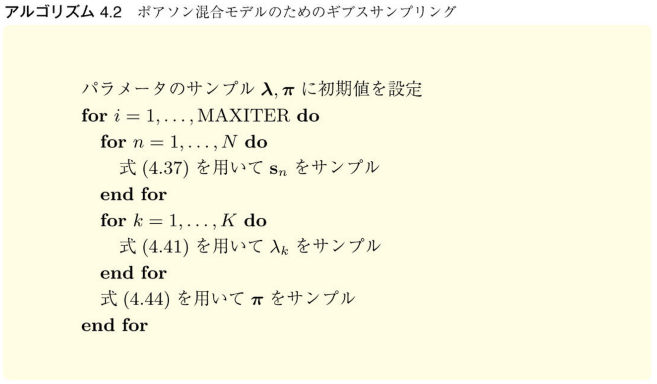



**各観測データに関するクラスタ$s_n$の近似事後分布を更新の上、$s_n$をサンプリングする**  
ギブスサンプリングなので直前にサンプリングされた$\lambda_k$を用いて更新する.

$$
\begin{aligned}
s_n &\sim Cat(s_n|\mathbf{\eta}_n) \\
\eta_{n,k} &\propto exp\{x_n ln \lambda_k -\lambda_k + ln \pi_k\} \\
s.t. &  \sum^K_{k=1} \eta_{n,k} = 1
\end{aligned}
$$

**各クラスタのポアソン分布のパラメータ$\lambda_k$の近似事後分布を更新の上、$\lambda_k$をサンプリングする**  
ギブスサンプリングなので直前にサンプリングされた$s_{n,k}$を用いて更新する.　　
K個の独立したガンマ分布からサンプリングする  

$$
\begin{aligned}
\lambda_k &\sim Gam(\lambda_k|\hat a_k, \hat b_k) \\
\hat a_k &= \sum^N_{n=1} s_{n,k} x_n + a\\
\hat b_k &= \sum^N_{n=1} s_{n,k} + b
\end{aligned}
$$



**重みの$\mathbf{\pi}$の近似事後分布を更新の上、$\pi_k$をサンプリングする**  
ギブスサンプリングなので直前にサンプリングされた$s_{n,k}$を用いて更新する.   
ディリクレ分布からサンプリングする  
$$
\begin{aligned}
\mathbf{\pi} &\sim Dir(\mathbf{\pi}|\mathbf{\hat \alpha}) \\
\mathbf{\hat \alpha} &= \sum^N_{n=1} s_{n,k} + \alpha_k
\end{aligned}
$$


#### 初期値の設定



事前分布からサンプリングにより設定する

#### 推論

### 変分推論


**アルゴリズム**  
機械学習スタートアップシリーズ ベイズ推論による機械学習入門 (KS情報科学専門
書) 須山 敦志  (著), 杉山 将 (監修)
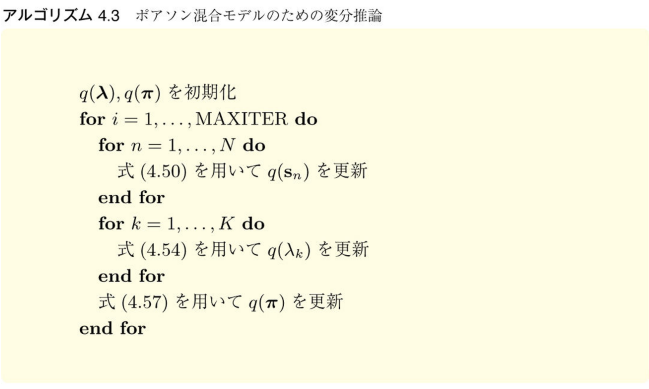


**各観測データに関するクラスタ$q(s_n)$の近似分布を更新する**  
* 変分推論なので直前に現時点での$\lambda_{k}$の推定期待値$\langle \lambda_k \rangle$を用いて更新する.
$$
\begin{aligned}
q(s_n) &\sim Cat(s_n|\mathbf{\eta}_n) \\
\eta_{n,k} &\propto exp\{x_n \langle ln  \lambda_k \rangle - \langle \lambda_k  \rangle + \langle ln \pi_k\  \rangle \} \\
s.t. &  \sum^K_{k=1} \eta_{n,k} = 1
\end{aligned}
$$

**各クラスタのポアソン分布のパラメータ$\lambda_k$の近似分布$q(\lambda_k)$を更新の上、$\lambda_k$をサンプリングする**  
* 変分推論なので直前に現時点での$s_{n,k}$の推定期待値$\langle s_{n,k} \rangle$を用いて更新する.
* K個の独立したガンマ分布からサンプリングする  

$$
\begin{aligned}
\lambda_k &\sim Gam(\lambda_k|\hat a_k, \hat b_k) \\
\hat a_k &= \sum^N_{n=1} \langle s_{n,k} \rangle x_n + a\\
\hat b_k &= \sum^N_{n=1} \langle s_{n,k} \rangle + b
\end{aligned}
$$



**重みの$\mathbf{\pi}$の近似分布$q(\pi)$を更新の上、$\pi$をサンプリングする**  
* 変分推論なので直前に現時点での$\lambda_{k}$の推定期待値$\langle \lambda_k \rangle$を用いて更新する.
ディリクレ分布からサンプリングする  
$$
\begin{aligned}
\mathbf{\pi} &\sim Dir(\mathbf{\pi}|\mathbf{\hat \alpha}) \\
\mathbf{\hat \alpha} &= \sum^N_{n=1} \langle s_{n,k} \rangle + \alpha_k
\end{aligned}
$$


#### 推論

### 崩壊型ギブスサンプリング

**アルゴリズム**

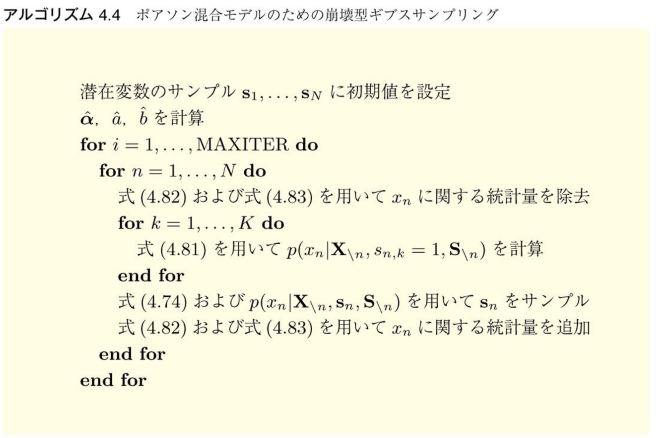

#### 初期値の設定

In [ ]:
# 潜在変数のサンプルに初期値を設定
s_nk = np.random.multinomial(n=1,pvals=alpha_k / np.sum(alpha_k), size=N) 

# 初期値によるlambdaの事後分布のパラメータを計算:式(4.24)
a_hat_k = np.sum(s_nk.T * x_n, axis=1) + a0
b_hat_k = np.sum(s_nk, axis=0) + b0

# 初期値によるpiの事後分布のパラメータを計算:式(4.45)
alpha_hat_k = np.sum(s_nk, axis=0) + alpha_k

初期値におけるlambdaの近似事後分布を描画

In [ ]:
posterior_lambda_k = [gamma.pdf(x=lambda_line, a=a_hat_k[k], scale=1/b_hat_k[k]) for k in range(K)]

# dataの設定

data = [go.Scatter(x=x_line, y= posterior_lambda_k[k],mode='lines',name=f"q(lambda_{k})") \
           for k in range(K)]

# レイアウトの指定
layout = go.Layout(
    width = 1000,
    height =500,
    xaxis = dict(title="value", dtick=10),     # dtick でラベルの表示間隔
    yaxis = dict(title="Prob"),
    bargap = 0.01) # 棒の間隔
fig = go.Figure(data=data,
                layout=layout)
fig.show()

初期値における混合ポアソン分布を描画

In [ ]:
lambda_k_exp = a_hat_k / b_hat_k

# piの平均値を計算:式(2.51)
pi_k_exp = alpha_hat_k / np.sum(alpha_hat_k)

In [ ]:
prob_k = [pi_k_exp[k] * poisson.pmf(k=x_line, mu=lambda_k_exp[k]) for k in range(K)] # 各クラスタの確率
prob = np.sum(prob_k,axis=0)

# dataの設定
total = go.Scatter(x=x_line, y= prob,mode='lines',name=f"total")
cluster = [go.Scatter(x=x_line, y= prob_k[k],mode='lines',name=f"cluster {k}") \
           for k in range(K)]

# レイアウトの指定
layout = go.Layout(
    width = 1000,
    height =500,
    xaxis = dict(title="value", dtick=10),     # dtick でラベルの表示間隔
    yaxis = dict(title="count"),
    bargap = 0.01) # 棒の間隔

fig = go.Figure(data=[total,*cluster],
                layout=layout)
fig.show()

#### 推論

推論の設定と履歴格納データクラス用意

In [ ]:
n_trials = 100
hist = History(K=3, Iter=n_trials)

In [ ]:
_, s_n = np.where(s_nk == 1)

In [ ]:
for i in range(n_trials):
    for n in range(N):
        # n番目のデータのクラスタ番号を取得

        # n番目のデータに関する統計量を除算

        # 
        

## 観測モデル (Mixture Poisson model) を設定

混合ポアソンモデルを設定する  
K個のポアソン分布の混合モデルだとしたとき、


$\pi_k$: k番目のポアソン分布の重み  
$\lambda_k$ k番目のポアソン分布のパラメータ

In [45]:
# 混合ガウス分布のパラメータを設定
lambda_k_truth = np.array([5.0, 15.0, 28.0,55.0,70.0,86.0])
pi_k_truth = np.array([0.1, 0.3, 0.2,0.1,0.2,0.1])

# クラスタ数
K= len(lambda_k_truth)
assert len(pi_k_truth)==K

描画

In [58]:
x_line = np.arange(0, 2 * np.max(lambda_k_truth))
lambda_line = np.arange(0, 2 * np.max(lambda_k_truth))

データの生成

In [47]:
N = 500

_, obs_s_truth = np.where(np.random.multinomial(n=1, pvals=pi_k_truth, size = N )==1) # 各観測データの真のクラスタS

# 観測データを生成する
x_n = np.random.poisson(lam=lambda_k_truth[obs_s_truth], size=N)


観測データを可視化

In [48]:
# dataの設定
data = go.Histogram(x=x_n, 
                    xbins=dict(start=0, end=101, size=1))
# レイアウトの指定
layout = go.Layout(
    width = 1000,
    height =500,
    xaxis = dict(title="value", dtick=10),     # dtick でラベルの表示間隔
    yaxis = dict(title="count"),
    bargap = 0.01) # 棒の間隔
fig = go.Figure(data=data,
                layout=layout)
fig.show()

In [49]:
x_line = np.arange(0, 2 * np.max(lambda_k_truth))
prob_k_truth = [pi_k_truth[k] * poisson.pmf(k=x_line, mu=lambda_k_truth[k]) for k in range(K)] # 各クラスタの確率
prob_truth = np.sum(prob_k_truth,axis=0)


# dataの設定
data = [go.Scatter(x=x_line, y= prob_truth,mode='lines',name=f"total")]
cluster = [go.Scatter(x=x_line, y= prob_k_truth[k],mode='lines',name=f"cluster {k}") \
           for k in range(K)]
data.extend(cluster)
# レイアウトの指定
layout = go.Layout(
    width = 1000,
    height =500,
    xaxis = dict(title="value", dtick=10),     # dtick でラベルの表示間隔
    yaxis = dict(title="count"),
    bargap = 0.01) # 棒の間隔
fig = go.Figure(data=data,
                layout=layout)
fig.show()

## 解析設定

In [50]:
@dataclasses.dataclass
class History:
    K:int
    Iter:int

    def __post_init__(self):
    
        self.a_k = np.empty((self.Iter+1,self.K))
        self.b_k = np.empty((self.Iter+1,self.K))
        self.alpha_k = np.empty((self.Iter+1,self.K))

        self.lambda_k = np.empty((self.Iter+1,self.K))
        self.pi_k = np.empty((self.Iter+1,self.K))
        
        self.time = np.empty(self.Iter+1)

        self.elbo = np.empty(self.Iter+1)

In [59]:
def make_result_anim(hist):
    fig = make_subplots(
    rows=1, cols=2, subplot_titles=('Lambda Posterior', 'Poisson Mixture'),
    horizontal_spacing=0.051)

    prior_lambda_k =  [gamma.pdf(x=lambda_line, a=hist.a_k[0,k], scale=1/hist.b_k[0,k]) for k in range(K)]
    prob_k = [hist.pi_k[0,k] * poisson.pmf(k=x_line, mu=hist.lambda_k[0,k]) for k in range(K)] 
    prob = np.sum(prob_k,axis=0)

    ## set trace
    # lambdaの事後分布
    for k in range(K):
        fig.add_trace(go.Scatter(x=lambda_line,
                    y= prior_lambda_k[k],
                    mode='lines',
                    name=f"q(lambda_{k})",
                    line = dict(color=list_color[k])),
                    row=1, col=1) # trance 0-K
    # 真のlambda
    for k in range(K):
        fig.add_shape(
            go.layout.Shape(type='line', xref='x', yref='paper',
                            x0=lambda_k_truth[k], y0=0, x1=lambda_k_truth[k], y1=1.0, line={'dash': 'dash'}),
                    row=1,col=1
    )


    # 混合ポアソン分布
    fig.add_trace(
        go.Scatter(x=x_line,
                y= prob,
                mode='lines',
                name=f"Mixture-Poisson Dist"),
                row=1, col=2)
        
    for k in range(K):
        fig.add_trace(go.Scatter(x=x_line,
                    y= prob_k[k],
                    mode='lines',
                    name=f"Poisson_{k}",
                    line = dict(color=list_color[k])),
                    row=1, col=2)
    fig.add_trace(
        go.Scatter(x=x_line,
                y= prob_truth,
                mode='lines',
                name=f"Mixture-Poisson Dist Truth",
                line={'dash': 'dash'}),
                row=1, col=2)
    

    ## frame
    frames = []
    for i in range(1,hist.Iter+1):
        data = []
        layout = []

        # lambdaの事後分布
        posterior_lambda_k = [gamma.pdf(x=lambda_line, a=hist.a_k[i,k], scale=1/hist.b_k[i,k]) for k in range(K)]
        data.extend([go.Scatter(x=lambda_line, y= posterior_lambda_k[k],mode='lines') for k in range(K)])


        prob_k = [hist.pi_k[i,k] * poisson.pmf(k=x_line, mu=hist.lambda_k[i,k]) for k in range(K)] # 各クラスタの確率
        prob = np.sum(prob_k,axis=0)    
        data.append(go.Scatter(x=x_line, y= prob, mode='lines'))
        data.extend([go.Scatter(x=x_line, y= prob_k[k],mode='lines') for k in range(K)])
        frames.append(go.Frame(
            data=data,
            traces = list(range(len(data)))
        ))
        
    fig.frames=frames

    # ## layout

    button = dict(
                label='Play',
                method='animate',
                args=[None, dict(frame=dict(duration=100, redraw=False), 
                                transition=dict(duration=1),
                                fromcurrent=True,
                                mode='immediate')])
    fig.update_layout(updatemenus=[dict(type='buttons',
                                showactive=False,
                                y=0,
                                x=1.05,
                                xanchor='left',
                                yanchor='bottom',
                                buttons=[button] )
                                        ],
                    width=800, height=500)

    fig.show()



## ベイズ推論

In [52]:
class BI_Base():
    def __init__(self,x_n,K,a0,b0,alpha0_k):
        self.x_n = x_n
        self.N = len(x_n)
        self.K = K

        self.a0 = a0
        self.b0 = b0
        self.alpha0_k = alpha0_k

    def calc_elbo(self,X, a, b, alpha, a_hat, b_hat, alpha_hat, eta):
        e_lmd_k = a_hat / b_hat
        e_ln_lmd_k = psi(a_hat) - np.log(b_hat)
        e_pi_k = alpha_hat/np.sum(alpha_hat)
        e_ln_pi_k = psi(alpha_hat) - psi(np.sum(alpha_hat))
        e_s = eta

        e_1 = np.dot(X.reshape(len(X), 1), e_ln_lmd_k.reshape(1,K)) -e_lmd_k
        e_1 = np.sum(np.sum(e_1*e_s,axis=1))
        e_2 = np.sum(np.dot(e_s, e_ln_pi_k))
        e_3 = np.sum(np.dot(e_s, e_pi_k))
        e_4 = np.sum((a_hat-a)*e_ln_lmd_k - (b_hat -b ) * e_lmd_k)
        e_5 = np.sum((a_hat - alpha) * e_pi_k)
        elbo = e_1 + e_2 - e_3 - e_4 - e_5
        return elbo





In [53]:
class BI_Gibbs(BI_Base):
    def __init__(self,x_n,K,a0,b0,alpha0_k):
        super().__init__(x_n,K,a0,b0,alpha0_k)


        self.lambda_k = np.random.gamma(shape=a0, scale=1 / b0, size=self.K)
        self.pi_k = np.random.dirichlet(alpha=alpha0_k, size=1).reshape(self.K)


    def exec(self,n_trials=300):
        x_n = self.x_n
        N = self.N
        K = self.K
        hist = History(K=K, Iter=n_trials)
        ## 結果を記録
        hist.a_k[0,:]  = self.a0
        hist.b_k[0,:]  = self.b0
        hist.alpha_k[0,:]  = self.alpha0_k

        hist.lambda_k[0,:] = self.lambda_k   
        hist.pi_k[0,:] = self.pi_k

        lambda_k = self.lambda_k
        pi_k = self.pi_k

        eta_nk = np.empty((N, K))
        s_nk = np.empty((N, K))    

        time_start = time.time()
        for i in range(n_trials):
            # 観測データそれぞれに対してクラスタs_nをサンプリングする
            for n in range(N):

                # 各クラスタkのポアソン分のパラメータ\etaを計算
                eta_k = np.exp(x_n[n] * np.log(lambda_k) - lambda_k + np.log(pi_k)) 
                eta_nk[n] = eta_k/ np.sum(eta_k) # 正規化

                # クラスタをカテゴリカル分布からサンプル
                s_nk[n] = np.random.multinomial(n=1, pvals=eta_nk[n]) 
            

            ## lambda_kをサンプリング
            # lambdaの事後分布のパラメータを計算
            a_hat_k = np.sum(s_nk.T * x_n, axis = 1) + self.a0
            b_hat_k = np.sum(s_nk,axis =0) + self.b0

            # lambda_kをサンプリング
            lambda_k = np.random.gamma(shape=a_hat_k, scale=1 / b_hat_k, size=K)

            ## piをサンプリング
            # piの事後分布のパラメータ\alphaを計算
            alpha_hat_k = np.sum(s_nk, axis=0) + self.alpha0_k
            
            # piをサンプルリング
            pi_k = np.random.dirichlet(alpha=alpha_hat_k, size=1).reshape(K)

            # elboを計算
            elbo = self.calc_elbo(x_n,self.a0,self.b0,self.alpha0_k,
                                  a_hat_k,b_hat_k,alpha_hat_k,
                                  eta_nk)

            ## 結果を記録
            hist.a_k[i+1,:]  = a_hat_k
            hist.b_k[i+1,:]  = b_hat_k
            hist.alpha_k[i+1,:]  = alpha_hat_k

            hist.lambda_k[i+1,:] = lambda_k   
            hist.pi_k[i+1,:] = pi_k

            hist.elbo[i] = elbo

            hist.time[i] = time.time() - time_start

        return hist




In [54]:
class BI_VI(BI_Base):
    def __init__(self,x_n,K,a0,b0,alpha0_k):
        super().__init__(x_n,K,a0,b0,alpha0_k)

        # 潜在変数の事後分布の期待値を初期化
        s_nk_exp = np.random.rand(self.N, self.K)
        s_nk_exp /= np.sum(s_nk_exp, axis=1, keepdims=True) # 正規化

        # 初期値でのlambdaの事後分布のパラメータを計算
        self.a_hat_k = np.sum(s_nk_exp.T * self.x_n, axis=1) + self.a0
        self.b_hat_k = np.sum(s_nk_exp, axis=0) + self.b0

        # 初期値によるpiのパラメータを計算:式(4.58)
        self.alpha_hat_k = np.sum(s_nk_exp, axis=0) + self.alpha0_k

    def exec(self,n_trials=50):
        N = self.N
        K = self.K
        
        a_hat_k = self.a_hat_k
        b_hat_k = self.b_hat_k
        alpha_hat_k = self.alpha_hat_k
        
        hist = History(K=K, Iter=n_trials)

        ## 結果を記録
        hist.a_k[0,:]  = a_hat_k
        hist.b_k[0,:]  = b_hat_k
        hist.alpha_k[0,:]  = alpha_hat_k

        hist.lambda_k[0,:] = a_hat_k/b_hat_k
        hist.pi_k[0,:] = alpha_hat_k / np.sum(alpha_hat_k)    

        eta_nk = np.empty((N, K))
        s_nk_exp = np.empty((N, K))

        time_start = time.time()
        for i in range(n_trials):
            ## q(s_n)を更新
            # q(s_n)が依存するlambda_k, pi_kの期待値を計算する
            lmd_k_exp = a_hat_k / b_hat_k
            ln_lmd_k_exp = psi(a_hat_k) - np.log(b_hat_k)
            ln_pi_k_exp = psi(alpha_hat_k) - psi(np.sum(alpha_hat_k))
            
            for n in range(N):
                eta_k = np.exp(self.x_n[n] * ln_lmd_k_exp - lmd_k_exp + ln_pi_k_exp)
                eta_nk[n] = eta_k / np.sum(eta_k) # 正規化


                # q(s_n)が依存するs_nの期待値を計算
                s_nk_exp[n] = eta_nk[n].copy()
                # 

            ## lambda_kの事後分布q(lambda_k), pi_kの事後分布q(pi_k)のパラメータを更新
            a_hat_k = np.sum(s_nk_exp.T * x_n, axis=1) + self.a0
            b_hat_k = np.sum(s_nk_exp, axis=0) + self.b0

            alpha_hat_k = np.sum(s_nk_exp, axis=0) + self.alpha0_k

            # elboを計算
            elbo = self.calc_elbo(x_n,self.a0,self.b0,self.alpha0_k,
                                  a_hat_k,b_hat_k,alpha_hat_k,
                                  eta_nk)

            ## 結果を記録
            hist.a_k[i+1,:]  = a_hat_k
            hist.b_k[i+1,:]  = b_hat_k
            hist.alpha_k[i+1,:]  = alpha_hat_k

            hist.lambda_k[i+1,:] = a_hat_k/b_hat_k
            hist.pi_k[i+1,:] = alpha_hat_k / np.sum(alpha_hat_k)

            hist.elbo[i] = elbo

            hist.time[i] = time.time() - time_start
        return hist


In [55]:
class BI_CollapsedGibbs(BI_Base):
    def __init__(self,x_n,K,a0,b0,alpha0_k):
        super().__init__(x_n,K,a0,b0,alpha0_k)

        self.s_nk = np.random.multinomial(n=1, pvals=alpha0_k / np.sum(alpha0_k), size=self.N)

        # 初期値によるlambdaの事後分布のパラメータを計算:式(4.24)
        self.a_hat_k = np.sum(self.s_nk.T * x_n, axis=1) + a0
        self.b_hat_k = np.sum(self.s_nk, axis=0) + b0

        # 初期値によるpiの事後分布のパラメータを計算:式(4.45)
        self.alpha_hat_k = np.sum(self.s_nk, axis=0) + alpha0_k

    def exec(self,n_trials=300):
        x_n = self.x_n
        N = self.N
        K = self.K
        s_nk = self.s_nk
        a_hat_k = self.a_hat_k
        b_hat_k = self.b_hat_k
        alpha_hat_k = self.alpha_hat_k
        ## 結果を記録
        hist = History(K=K, Iter=n_trials)
        hist.a_k[0,:]  = self.a0
        hist.b_k[0,:]  = self.b0
        hist.alpha_k[0,:]  = self.alpha0_k
        hist.lambda_k[0,:] = a_hat_k/b_hat_k
        hist.pi_k[0,:] = alpha_hat_k / np.sum(alpha_hat_k)

        eta = np.empty((N, K))
        
        time_start = time.time()
        for i in range(n_trials):
            for n in range(N):
                # n番目のデータの現在のクラスタ番号を取得
                k, = np.where(s_nk[n] == 1)[0]
                
                # n番目のデータに関する統計量を除算
                a_hat_k[k] = a_hat_k[k] - x_n[n]
                b_hat_k[k] = b_hat_k[k] - 1
                alpha_hat_k[k] = alpha_hat_k[k] - 1
                
                # 負の二項分布(4.81)のパラメータを計算
                r_hat_k = a_hat_k
                p_hat_k = 1 / (b_hat_k + 1)
                
                # 負の二項分布の確率を計算:式(4.81)
                prob_nb_k = nbinom.pmf(k=x_n[n], n=r_hat_k, p=1 - p_hat_k)
                
                # カテゴリ分布(4.74)のパラメータを計算:式(4.75)
                eta_k = alpha_hat_k / np.sum(alpha_hat_k)
                
                # n番目のクラスタのサンプリング確率を計算:式(4.66)
                prob_s_k = (prob_nb_k + 1e-7) * eta_k
                prob_s_k = prob_s_k / np.sum(prob_s_k) # 正規化
                
                # n番目のクラスタをサンプル:式(4.74)
                s_nk[n] = np.random.multinomial(n=1, pvals=prob_s_k, size=1)
                
                # n番目のデータの新しいクラスタを取得
                k, = np.where(s_nk[n] == 1)[0]
                
                # n番目のデータに関する統計量を加算:式(4.82-4.83)
                a_hat_k[k] = a_hat_k[k] + x_n[n]
                b_hat_k[k] = b_hat_k[k] + 1
                alpha_hat_k[k] = alpha_hat_k[k] + 1
            
                eta[n] = prob_s_k
            # elboを計算
            elbo = self.calc_elbo(x_n,self.a0,self.b0,self.alpha0_k,
                                    a_hat_k,b_hat_k,alpha_hat_k,
                                    eta)

            ## 結果を記録
            hist.a_k[i+1,:]  = a_hat_k
            hist.b_k[i+1,:]  = b_hat_k
            hist.alpha_k[i+1,:]  = alpha_hat_k

            hist.lambda_k[i+1,:] = a_hat_k/b_hat_k
            hist.pi_k[i+1,:] = alpha_hat_k / np.sum(alpha_hat_k)

            hist.elbo[i] = elbo

            hist.time[i] = time.time() - time_start

        return hist




In [62]:
bi_gibbs = BI_Gibbs(x_n=x_n,K=K,a0=1.0,b0=1.0,alpha0_k=np.repeat(2.0,K))
hist = bi_gibbs.exec(n_trials=100)

In [ ]:
make_result_anim(hist)


In [100]:
bi_vi = BI_VI(x_n=x_n,K=6,a0=1.0,b0=1.0,alpha0_k=np.repeat(2.0,K))
hist = bi_vi.exec(n_trials=30)

In [ ]:
make_result_anim(hist)


In [168]:
 
bi_cgibbs = BI_CollapsedGibbs(x_n=x_n,K=6,a0=1.0,b0=1.0,alpha0_k=np.repeat(2.0,K))
hist = bi_cgibbs.exec(n_trials=30)

In [108]:
make_result_anim(hist)


array([ 2.52931118e-02, -1.86293630e+04, -1.45164772e+04, -1.05161597e+04,
       -9.14601040e+03, -8.64015397e+03, -8.51087435e+03, -8.39826439e+03,
       -8.14102490e+03, -7.94612326e+03, -7.79914614e+03, -7.64245224e+03,
       -7.48677110e+03, -7.39931808e+03, -7.36780775e+03, -7.21227587e+03,
       -7.25069525e+03, -7.21393547e+03, -7.15453182e+03, -7.23476400e+03,
       -7.20201820e+03, -7.12681380e+03, -7.06457872e+03, -7.03990212e+03,
       -7.11894207e+03, -7.18265390e+03, -7.17689579e+03, -7.08752698e+03,
       -7.19375853e+03, -7.12776029e+03, -7.15397822e+03])

In [169]:
make_result_anim(hist)


## 実験

計算時間とELBO

In [181]:
K=6
j = 10

In [182]:

gs_list =[]
for i in range(j):
    bi = BI_Gibbs(x_n=x_n,K=K,a0=1.0,b0=1.0,alpha0_k=np.repeat(2.0,K))
    hist = bi.exec(n_trials=100)
    gs_list.append(hist)

In [183]:

vi_list =[]
for i in range(j):
    bi = BI_VI(x_n=x_n,K=K,a0=1.0,b0=1.0,alpha0_k=np.repeat(2.0,K))
    hist = bi.exec(n_trials=100)
    vi_list.append(hist)

In [184]:

cgs_list =[]
for i in range(j):
    bi = BI_CollapsedGibbs(x_n=x_n,K=K,a0=1.0,b0=1.0,alpha0_k=np.repeat(2.0,K))
    hist = bi.exec(n_trials=100)
    cgs_list.append(hist)

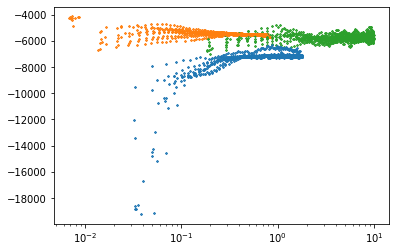

In [185]:

for i in range(j):
    hist = gs_list[i]
    plt.scatter(hist.time[1:-1],hist.elbo[1:-1],c=list_color[0],alpha=0.9,marker="x",s=3)    

    hist = vi_list[i]
    plt.scatter(hist.time[1:-1],hist.elbo[1:-1],c=list_color[1],alpha=0.9,marker="x",s=3)    

    hist = cgs_list[i]
    plt.scatter(hist.time[1:-1],hist.elbo[1:-1],c=list_color[2],alpha=0.9,marker="x",s=3)    

ax = plt.gca()
ax.set_xscale('log')
plt.show()

<font color= "1F77B4">ギブスサンプリング</font>  
<font color= "FF7F0E">変分推論</font>  
<font color= "2CA02C">崩壊型ギブスサンプリング</font>

In [27]:
list_color

['#1F77B4',
 '#FF7F0E',
 '#2CA02C',
 '#D62728',
 '#9467BD',
 '#8C564B',
 '#E377C2',
 '#7F7F7F',
 '#BCBD22',
 '#17BECF']

コンポーネント数とELBO

In [22]:
j=20
gs_list =[]
elbo_list = []
for i in range(j):
    K=i+1
    bi = BI_Gibbs(x_n=x_n,K=K,a0=1.0,b0=1.0,alpha0_k=np.repeat(2.0,K))
    hist = bi.exec(n_trials=100)
    elbo_list.append(hist.elbo[-2])
    gs_list.append(hist)

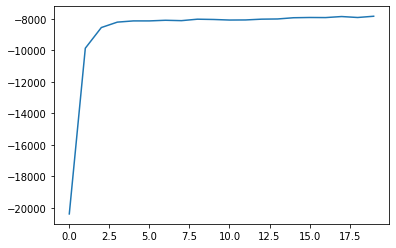

In [23]:
plt.plot(elbo_list)